In [20]:
import pandas as pd
import json
import csv
from pathlib import Path

In [3]:
path_ = '..\\data\\data_processed_all_stations.json'

with open(path_, 'r') as file:
    document = json.load(file)
    
df = pd.DataFrame(document)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 714 entries, 0 to 713
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CD_OSCAR            712 non-null    object 
 1   DC_NOME             714 non-null    object 
 2   FL_CAPITAL          714 non-null    object 
 3   DT_FIM_OPERACAO     714 non-null    int64  
 4   CD_SITUACAO         714 non-null    object 
 5   TP_ESTACAO          714 non-null    object 
 6   VL_LATITUDE         714 non-null    float64
 7   CD_WSI              712 non-null    object 
 8   CD_DISTRITO         714 non-null    int64  
 9   VL_ALTITUDE         714 non-null    float64
 10  SG_ESTADO           714 non-null    object 
 11  CD_ESTACAO          714 non-null    object 
 12  VL_LONGITUDE        714 non-null    float64
 13  DT_INICIO_OPERACAO  714 non-null    object 
 14  REGIAO              714 non-null    object 
dtypes: float64(3), int64(2), object(10)
memory usage: 83.8+ K

In [6]:
df[['REGIAO','DC_NOME', 'SG_ESTADO', 'CD_ESTACAO', 'TP_ESTACAO']].head()


,REGIAO,DC_NOME,SG_ESTADO,CD_ESTACAO,TP_ESTACAO
0,NORDESTE,ABROLHOS,BA,A422,Automatica
1,NORDESTE,ACARAU,CE,A360,Automatica
2,SUDESTE,AFONSO CLAUDIO,ES,A657,Automatica
3,CENTRO-OESTE,AGUA BOA,MT,A908,Automatica
4,CENTRO-OESTE,AGUA CLARA,MS,A756,Automatica


### Função reponsavel por verificar se sigla do estado está no mapa_regioes<br> Retorna o noma da regão

In [2]:
def obter_regiao_pelo_estado(estado):
    mapa_regioes = {
        'NORTE': ['AC', 'AM', 'AP', 'PA', 'RO', 'RR', 'TO'],
        'NORDESTE': ['AL', 'BA', 'CE', 'MA', 'PB', 'PE', 'PI', 'RN', 'SE'],
        'CENTRO-OESTE': ['DF', 'GO', 'MT', 'MS'],
        'SUDESTE': ['ES', 'MG', 'RJ', 'SP'],
        'SUL': ['PR', 'RS', 'SC']
    }

    for regiao, estados in mapa_regioes.items():
        if estado in estados:
            return regiao

    return 'Região não encontrada'

### Cria uma nova coluna no dataframe estações

In [8]:
def cria_coluna_regiao_no_datafrma(df):
    
    df['REGIAO'] = df['SG_ESTADO'].apply(lambda estado:  obter_regiao_pelo_estado(estado))


# SEÇÃO: CRIAR UMA LISTA DE ESTAÇÕES POR REGIÃO

In [42]:
# df_only_automaticas = df [['REGIAO','SG_ESTADO', 'DC_NOME', 'CD_ESTACAO', 'TP_ESTACAO']]  [df['TP_ESTACAO'] == 'Automatica'  ].sort_values('CD_ESTACAO', ascending=False)
df_only_automaticas = df [['REGIAO', 'CD_ESTACAO', 'TP_ESTACAO']]  [df['TP_ESTACAO'] == 'Automatica'  ].sort_values('CD_ESTACAO', ascending=False)

In [43]:
df_only_automaticas

,REGIAO,CD_ESTACAO,TP_ESTACAO
65,SUDESTE,F501,Automatica
398,SUL,B807,Automatica
142,SUL,B806,Automatica
285,SUL,B804,Automatica
99,SUL,B803,Automatica
...,...,...,...
355,NORTE,A009,Automatica
396,CENTRO-OESTE,A005,Automatica
329,CENTRO-OESTE,A003,Automatica
208,CENTRO-OESTE,A002,Automatica


In [41]:
#TP_ESTACAO
#Automatica      567
#Convencional    147


#df_only_automaticas [['REGIAO','SG_ESTADO', 'DC_NOME', 'CD_ESTACAO', 'TP_ESTACAO']]  [df_only_automaticas['REGIAO'] == 'NORTE'  ].sort_values('CD_ESTACAO', ascending=False)
df_only_automaticas [['REGIAO','SG_ESTADO', 'DC_NOME', 'CD_ESTACAO', 'TP_ESTACAO']]  [df_only_automaticas['REGIAO'] == 'NORTE'  ].sort_values('CD_ESTACAO', ascending=False)


,REGIAO,SG_ESTADO,DC_NOME,CD_ESTACAO,TP_ESTACAO
39,NORTE,RO,ARIQUEMES,A940,Automatica
89,NORTE,RO,CACOAL,A939,Automatica
561,NORTE,RO,VILHENA,A938,Automatica
404,NORTE,RO,PORTO VELHO,A925,Automatica
457,NORTE,PA,SANTA MARIA DAS BARREIRAS,A256,Automatica
...,...,...,...,...,...
378,NORTE,TO,PEDRO AFONSO,A020,Automatica
219,NORTE,TO,GURUPI,A019,Automatica
379,NORTE,TO,PEIXE,A018,Automatica
361,NORTE,TO,PARANA,A010,Automatica


In [79]:
from datetime import datetime, timedelta
import time
import requests
import os
from dotenv import load_dotenv



class ConnectAPI:
    
    def __init__(self) -> None:
        
        self.url_base = 'https://apitempo.inmet.gov.br'
        self.token = self.get_token()
        


    # obter token
    def get_token(self):
        
        load_dotenv()
        
        token1 = os.getenv('TOKEN1')
        token2 = os.getenv('TOKEN2')
        
        if token1 and token2 is not None:
            self.token = True
        else:
            raise ValueError('Token não encontrado.')
        
        return f'{token1}={token2}'
    
    
    
    # Obter os dados de uma url
    def get_data(self, url):
        response = requests.get(url)
        
        if response.status_code == 200:
            data = response.json()
            
        return data
        


    # obtem dados horarios baseados nos parametros
    def get_data_hour_of_station(self, data_inicial, data_final, station):

        url = f'{self.url_base}/token/estacao/{data_inicial}/{data_final}/{station}/{self.token}'
        print(url)
        
        data = self.get_data(url) 
        
        return data
        


    def incrementar_dia(self, start_day):
            
            # converte a data (string) para data(datetime)
            date_curent = datetime.strptime(start_day, '%Y-%m-%d').date()
            
            # recuperar a data de hoje
            data_hora_atual = datetime.now()
            data_de_hoje = data_hora_atual.date()
            
            # indentificar o interevalo entre data de hoje e a data inicial
            intervalo = (data_de_hoje - date_curent).days
                
            if intervalo >= 31:
                
                date_curent += timedelta(days=30)
            
            else:
                
                date_curent += timedelta(days=intervalo-1)
            
            new_start_day = date_curent.strftime('%Y-%m-%d')
            
            return new_start_day
        
        
    def get_data_hour_of_api(self, start_date, cod_estacao):
            
            dados_diarios = []  
            temp_date = datetime.strptime(start_date, '%Y-%m-%d').date()

            # recuperar a data de hoje
            data_hora_atual = datetime.now()
            data_de_hoje = data_hora_atual.date()
            
            while temp_date < data_de_hoje:
                
                end_date = self.incrementar_dia(start_date)
                
                dados_horarios_de_estacao = self.get_data_hour_of_station(start_date,end_date,cod_estacao)
                

                print({len(dados_horarios_de_estacao)})
                print(start_date, end_date)
                
                dados_diarios.extend(dados_horarios_de_estacao)
                
                temp_date = datetime.strptime(end_date, '%Y-%m-%d').date()
                temp_date = temp_date + timedelta(days=1)
                
                start_date = temp_date.strftime('%Y-%m-%d')
                time.sleep(30)
            
            return dados_diarios
        
    # função responsável por salvar dataframe em um arquivo json
    def salvar_dados_em_um_arquivo_json(self, df, nome_arquivo):
        
        path = self.obter_diretorio_data()
        
        df.to_json(f'{path}\{nome_arquivo}.json',orient='records')
        
        
    def obter_diretorio_data(self):
        try:
            # Obtém o caminho absoluto do script atual
            #caminho_do_diretorio_data = Path(__file__).parent.parent

            #caminho_completo = caminho_do_diretorio_data / 'data'
            
            path_ = '..\\data\\data_processed_all_stations.json'

            return path_
            
        except Exception as e:
            return f"Erro ao obter o diretório atual: {e}"
    
    
    # salva dados da api em um arquivo json
    def salvar_dados_brutos_de_uma_api_em_json(self, data, file_name):
        try:
            
            json_str = json.dumps(data, default=str)
            
            #diretorio = self.obter_diretorio_data()
            caminho_completo = '..\\data\\'f'{file_name}.json'

            with open(caminho_completo, 'w') as file:
                file.write(json_str)
            
            print('Arquivo salvo com sucesso!!')
            
        except (IOError, PermissionError) as e:
            print(f"Erro ao salvar dados em JSON: {e}")
            # Adicione aqui qualquer tratamento adicional que desejar
            
    
    # salva dados da api em um arquivo csv
    def export_csv(data, file_name):
        colunas = data[0].keys()

        with open(f'../data/{file_name}.csv', 'w', newline='') as file:
            writer = csv.DictWriter(file, fieldnames=colunas)      
            writer.writeheader()
            
            for linha in data:
                writer.writerow(linha)
                
    
    # função que obtem dados horarios da api de uma regiao
    def get_data_hour_of_api_per_region(self, start_date, lista_de_estacoes):
        
        temp_dados = []
        
        for estacao in lista_de_estacoes:
            dados = self.get_data_hour_of_api(start_date, estacao)
            temp_dados.extend(dados)
            print('tamanho: ', len(temp_dados))
            print('estação: ', estacao)
            
        return temp_dados
    
    
    # função quue ler os dados de um arquivo json
    def ler_arquivo_json(self, nome_arquivo):
        
        
        path_ = self.obter_diretorio_data()
        #full_path = f'{path_}\{nome_arquivo}.json'
        
        with open(path_, 'r') as file:
            document = json.load(file)
            
        return document
    
    
    
    def get_lista_estacoes_por_regiao(self, nome_regiao):
    
        dados =  self.ler_arquivo_json('data_processed_all_stations')
        
        df_only_automaticas = pd.DataFrame(dados)
        
        df_only_automaticas = df_only_automaticas [['REGIAO','SG_ESTADO', 'DC_NOME', 'CD_ESTACAO', 'TP_ESTACAO']]  [df_only_automaticas['TP_ESTACAO'] == 'Automatica'  ].sort_values('CD_ESTACAO', ascending=False)
        
        series_de_estacoes = df_only_automaticas [['CD_ESTACAO']]  [df_only_automaticas['REGIAO'] == nome_regiao  ].sort_values('CD_ESTACAO', ascending=False)
        lista_de_estacoes = list(series_de_estacoes['CD_ESTACAO'])
        
        return lista_de_estacoes

In [23]:
connect = ConnectAPI()

start_date = '2024-01-01'
lista_de_estacoes = connect.get_lista_estacoes_por_regiao('SUDESTE')
dados = connect.get_data_hour_of_api_per_region(start_date, lista_de_estacoes)


https://apitempo.inmet.gov.br/token/estacao/2024-01-01/2024-01-31/F501/cFRCVjVEdWdEUXZ6cVZ6N2tmRFI1YVF1WUVmT0lTaDk=pTBV5DugDQvzqVz7kfDR5aQuYEfOISh9
{744}
2024-01-01 2024-01-31
tamanho:  744
estação:  F501
https://apitempo.inmet.gov.br/token/estacao/2024-01-01/2024-01-31/A771/cFRCVjVEdWdEUXZ6cVZ6N2tmRFI1YVF1WUVmT0lTaDk=pTBV5DugDQvzqVz7kfDR5aQuYEfOISh9
{744}
2024-01-01 2024-01-31
tamanho:  1488
estação:  A771
https://apitempo.inmet.gov.br/token/estacao/2024-01-01/2024-01-31/A770/cFRCVjVEdWdEUXZ6cVZ6N2tmRFI1YVF1WUVmT0lTaDk=pTBV5DugDQvzqVz7kfDR5aQuYEfOISh9
{744}
2024-01-01 2024-01-31
tamanho:  2232
estação:  A770
https://apitempo.inmet.gov.br/token/estacao/2024-01-01/2024-01-31/A769/cFRCVjVEdWdEUXZ6cVZ6N2tmRFI1YVF1WUVmT0lTaDk=pTBV5DugDQvzqVz7kfDR5aQuYEfOISh9
{744}
2024-01-01 2024-01-31
tamanho:  2976
estação:  A769
https://apitempo.inmet.gov.br/token/estacao/2024-01-01/2024-01-31/A768/cFRCVjVEdWdEUXZ6cVZ6N2tmRFI1YVF1WUVmT0lTaDk=pTBV5DugDQvzqVz7kfDR5aQuYEfOISh9
{744}
2024-01-01 2024-01-31
t

In [24]:
# qtd de documentos na região sudeste
len(dados)

108624

In [15]:
lista_de_estacoes = connect.get_lista_estacoes_por_regiao('SUDESTE')
len(lista_de_estacoes)

146

In [26]:
json_str = json.dumps(dados, default=str)

with open('../data/data_raw_sudeste_january_2024.json', 'w') as file:
    file.write(json_str)
            
print('Arquivo salvo com sucesso!!')

Arquivo salvo com sucesso!!


In [27]:
df = pd.DataFrame(dados)

In [28]:
df.head(23)

,DC_NOME,PRE_INS,TEM_SEN,VL_LATITUDE,PRE_MAX,UF,RAD_GLO,PTO_INS,TEM_MIN,VL_LONGITUDE,...,VEN_VEL,PTO_MIN,TEM_MAX,TEN_BAT,VEN_RAJ,TEM_CPU,TEM_INS,UMD_INS,CD_ESTACAO,HR_MEDICAO
0,BELO HORIZONTE - CERCADINHO,880.7,7.2,-19.97999999,881,MG,0.1,17,18.5,-43.95861111,...,10.8,17,19.1,12.5,15.7,21,18.5,91,F501,0000
1,BELO HORIZONTE - CERCADINHO,881.3,7.9,-19.97999999,881.3,MG,0,16.9,18.4,-43.95861111,...,9.8,16.9,18.5,12.5,15.5,21,18.4,91,F501,0100
2,BELO HORIZONTE - CERCADINHO,881.6,6.9,-19.97999999,881.7,MG,0,16.7,18.2,-43.95861111,...,10.5,16.7,18.4,12.5,13.8,20,18.2,91,F501,0200
3,BELO HORIZONTE - CERCADINHO,881.6,9.3,-19.97999999,881.8,MG,0,16.6,18.1,-43.95861111,...,7.5,16.6,18.2,12.5,13.3,20,18.1,91,F501,0300
4,BELO HORIZONTE - CERCADINHO,881.5,12.9,-19.97999999,881.7,MG,0,16.6,18,-43.95861111,...,4.6,16.5,18.1,12.5,9.9,20,18.1,91,F501,0400
5,BELO HORIZONTE - CERCADINHO,881.3,15.2,-19.97999999,881.5,MG,0,16.8,18,-43.95861111,...,3.5,16.5,18.3,12.5,7.9,20,18.3,91,F501,0500
6,BELO HORIZONTE - CERCADINHO,880.4,9.1,-19.97999999,881.3,MG,0.1,16.4,17.9,-43.95861111,...,7.4,16.4,18.3,12.4,9.4,20,17.9,91,F501,0600
7,BELO HORIZONTE - CERCADINHO,880.1,5.6,-19.97999999,880.4,MG,0.3,15.8,17.2,-43.95861111,...,9.9,15.8,17.9,12.4,14.1,20,17.2,91,F501,0700
8,BELO HORIZONTE - CERCADINHO,880.3,6.1,-19.97999999,880.3,MG,0,15.7,17.1,-43.95861111,...,9.1,15.7,17.2,12.4,14.3,19,17.1,91,F501,0800
9,BELO HORIZONTE - CERCADINHO,881,8.1,-19.97999999,881,MG,12.6,15.8,17.1,-43.95861111,...,7.2,15.6,17.2,12.4,11.9,19,17.2,91,F501,0900


# Extraindo dados da região CENTRO-OESTE

In [30]:
lista_de_estacoes = connect.get_lista_estacoes_por_regiao('CENTRO-OESTE')
len(lista_de_estacoes)

96

In [31]:
connect = ConnectAPI()

start_date = '2024-01-01'
lista_de_estacoes = connect.get_lista_estacoes_por_regiao('CENTRO-OESTE')
dados_centro_oeste = connect.get_data_hour_of_api_per_region(start_date, lista_de_estacoes)


https://apitempo.inmet.gov.br/token/estacao/2024-01-01/2024-01-31/A944/cFRCVjVEdWdEUXZ6cVZ6N2tmRFI1YVF1WUVmT0lTaDk=pTBV5DugDQvzqVz7kfDR5aQuYEfOISh9
{744}
2024-01-01 2024-01-31
tamanho:  744
estação:  A944
https://apitempo.inmet.gov.br/token/estacao/2024-01-01/2024-01-31/A943/cFRCVjVEdWdEUXZ6cVZ6N2tmRFI1YVF1WUVmT0lTaDk=pTBV5DugDQvzqVz7kfDR5aQuYEfOISh9
{744}
2024-01-01 2024-01-31
tamanho:  1488
estação:  A943
https://apitempo.inmet.gov.br/token/estacao/2024-01-01/2024-01-31/A942/cFRCVjVEdWdEUXZ6cVZ6N2tmRFI1YVF1WUVmT0lTaDk=pTBV5DugDQvzqVz7kfDR5aQuYEfOISh9
{744}
2024-01-01 2024-01-31
tamanho:  2232
estação:  A942
https://apitempo.inmet.gov.br/token/estacao/2024-01-01/2024-01-31/A937/cFRCVjVEdWdEUXZ6cVZ6N2tmRFI1YVF1WUVmT0lTaDk=pTBV5DugDQvzqVz7kfDR5aQuYEfOISh9
{744}
2024-01-01 2024-01-31
tamanho:  2976
estação:  A937
https://apitempo.inmet.gov.br/token/estacao/2024-01-01/2024-01-31/A936/cFRCVjVEdWdEUXZ6cVZ6N2tmRFI1YVF1WUVmT0lTaDk=pTBV5DugDQvzqVz7kfDR5aQuYEfOISh9
{744}
2024-01-01 2024-01-31
t

In [32]:
json_str = json.dumps(dados_centro_oeste, default=str)

with open('../data/data_raw_centro_oeste_january_2024.json', 'w') as file:
    file.write(json_str)
            
print('Arquivo salvo com sucesso!!')

Arquivo salvo com sucesso!!


In [34]:
len(dados_centro_oeste)

71424

# Extraindo dados da região NORDESTE

In [33]:
lista_de_estacoes = connect.get_lista_estacoes_por_regiao('NORDESTE')
len(lista_de_estacoes)

142

In [35]:
connect = ConnectAPI()

start_date = '2024-01-01'
lista_de_estacoes = connect.get_lista_estacoes_por_regiao('NORDESTE')
dados_nordeste = connect.get_data_hour_of_api_per_region(start_date, lista_de_estacoes)

https://apitempo.inmet.gov.br/token/estacao/2024-01-01/2024-01-31/A458/cFRCVjVEdWdEUXZ6cVZ6N2tmRFI1YVF1WUVmT0lTaDk=pTBV5DugDQvzqVz7kfDR5aQuYEfOISh9
{744}
2024-01-01 2024-01-31
tamanho:  744
estação:  A458
https://apitempo.inmet.gov.br/token/estacao/2024-01-01/2024-01-31/A456/cFRCVjVEdWdEUXZ6cVZ6N2tmRFI1YVF1WUVmT0lTaDk=pTBV5DugDQvzqVz7kfDR5aQuYEfOISh9
{744}
2024-01-01 2024-01-31
tamanho:  1488
estação:  A456
https://apitempo.inmet.gov.br/token/estacao/2024-01-01/2024-01-31/A455/cFRCVjVEdWdEUXZ6cVZ6N2tmRFI1YVF1WUVmT0lTaDk=pTBV5DugDQvzqVz7kfDR5aQuYEfOISh9
{744}
2024-01-01 2024-01-31
tamanho:  2232
estação:  A455
https://apitempo.inmet.gov.br/token/estacao/2024-01-01/2024-01-31/A453/cFRCVjVEdWdEUXZ6cVZ6N2tmRFI1YVF1WUVmT0lTaDk=pTBV5DugDQvzqVz7kfDR5aQuYEfOISh9
{744}
2024-01-01 2024-01-31
tamanho:  2976
estação:  A453
https://apitempo.inmet.gov.br/token/estacao/2024-01-01/2024-01-31/A452/cFRCVjVEdWdEUXZ6cVZ6N2tmRFI1YVF1WUVmT0lTaDk=pTBV5DugDQvzqVz7kfDR5aQuYEfOISh9
{744}
2024-01-01 2024-01-31
t

In [37]:
len(dados_nordeste)

105648

In [38]:
json_str = json.dumps(dados_nordeste, default=str)

with open('../data/data_raw_nordeste_january_2024.json', 'w') as file:
    file.write(json_str)
            
print('Arquivo salvo com sucesso!!')

Arquivo salvo com sucesso!!


# Extraindo dados da região SUL

In [40]:
lista_de_estacoes = connect.get_lista_estacoes_por_regiao('SUL')
len(lista_de_estacoes)

95

In [41]:
connect = ConnectAPI()

start_date = '2024-01-01'
lista_de_estacoes = connect.get_lista_estacoes_por_regiao('SUL')
dados_sul = connect.get_data_hour_of_api_per_region(start_date, lista_de_estacoes)

https://apitempo.inmet.gov.br/token/estacao/2024-01-01/2024-01-31/B807/cFRCVjVEdWdEUXZ6cVZ6N2tmRFI1YVF1WUVmT0lTaDk=pTBV5DugDQvzqVz7kfDR5aQuYEfOISh9
{744}
2024-01-01 2024-01-31
tamanho:  744
estação:  B807
https://apitempo.inmet.gov.br/token/estacao/2024-01-01/2024-01-31/B806/cFRCVjVEdWdEUXZ6cVZ6N2tmRFI1YVF1WUVmT0lTaDk=pTBV5DugDQvzqVz7kfDR5aQuYEfOISh9
{744}
2024-01-01 2024-01-31
tamanho:  1488
estação:  B806
https://apitempo.inmet.gov.br/token/estacao/2024-01-01/2024-01-31/B804/cFRCVjVEdWdEUXZ6cVZ6N2tmRFI1YVF1WUVmT0lTaDk=pTBV5DugDQvzqVz7kfDR5aQuYEfOISh9
{744}
2024-01-01 2024-01-31
tamanho:  2232
estação:  B804
https://apitempo.inmet.gov.br/token/estacao/2024-01-01/2024-01-31/B803/cFRCVjVEdWdEUXZ6cVZ6N2tmRFI1YVF1WUVmT0lTaDk=pTBV5DugDQvzqVz7kfDR5aQuYEfOISh9
{744}
2024-01-01 2024-01-31
tamanho:  2976
estação:  B803
https://apitempo.inmet.gov.br/token/estacao/2024-01-01/2024-01-31/A899/cFRCVjVEdWdEUXZ6cVZ6N2tmRFI1YVF1WUVmT0lTaDk=pTBV5DugDQvzqVz7kfDR5aQuYEfOISh9
{744}
2024-01-01 2024-01-31
t

In [42]:
len(dados_sul)

70680

In [43]:
json_str = json.dumps(dados_sul, default=str)

with open('../data/data_raw_sul_january_2024.json', 'w') as file:
    file.write(json_str)
            
print('Arquivo salvo com sucesso!!')

Arquivo salvo com sucesso!!


# Callback (rertornar grandeza)

In [85]:
path_ = '..\\data\\data_raw_norte_january_2024.json'

with open(path_, 'r') as file:
    document = json.load(file)
    
df_norte = pd.DataFrame(document)

In [89]:
df_test = df_norte[df_norte['UF'] == 'AM']
df_test['CD_ESTACAO'].iloc[0]

'A144'

In [22]:
df_norte.columns

Index(['DC_NOME', 'PRE_INS', 'TEM_SEN', 'VL_LATITUDE', 'PRE_MAX', 'UF',
       'RAD_GLO', 'PTO_INS', 'TEM_MIN', 'VL_LONGITUDE', 'UMD_MIN', 'PTO_MAX',
       'VEN_DIR', 'DT_MEDICAO', 'CHUVA', 'PRE_MIN', 'UMD_MAX', 'VEN_VEL',
       'PTO_MIN', 'TEM_MAX', 'TEN_BAT', 'VEN_RAJ', 'TEM_CPU', 'TEM_INS',
       'UMD_INS', 'CD_ESTACAO', 'HR_MEDICAO'],
      dtype='object')

In [24]:
df_estado = df_norte[df_norte['UF'] == 'AM']
df_estado

,DC_NOME,PRE_INS,TEM_SEN,VL_LATITUDE,PRE_MAX,UF,RAD_GLO,PTO_INS,TEM_MIN,VL_LONGITUDE,...,VEN_VEL,PTO_MIN,TEM_MAX,TEN_BAT,VEN_RAJ,TEM_CPU,TEM_INS,UMD_INS,CD_ESTACAO,HR_MEDICAO
30504,NOVO ARIPUANÃ,None,None,-8.0911111,None,AM,None,None,None,-60.38055554,...,None,None,None,None,None,None,None,None,A144,0000
30505,NOVO ARIPUANÃ,None,None,-8.0911111,None,AM,None,None,None,-60.38055554,...,None,None,None,None,None,None,None,None,A144,0100
30506,NOVO ARIPUANÃ,None,None,-8.0911111,None,AM,None,None,None,-60.38055554,...,None,None,None,None,None,None,None,None,A144,0200
30507,NOVO ARIPUANÃ,None,None,-8.0911111,None,AM,None,None,None,-60.38055554,...,None,None,None,None,None,None,None,None,A144,0300
30508,NOVO ARIPUANÃ,None,None,-8.0911111,None,AM,None,None,None,-60.38055554,...,None,None,None,None,None,None,None,None,A144,0400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50587,MANAUS,1001.5,33.5,-3.10333333,1003,AM,2174.2,23,31.9,-60.01638888,...,2.7,22.9,33.7,13.4,7.3,36,33,56,A101,1900
50588,MANAUS,1000.9,35.3,-3.10333333,1001.5,AM,1992.5,24,32.4,-60.01638888,...,1.5,22.4,33.7,13.4,6.1,36,33.5,58,A101,2000
50589,MANAUS,1000.6,32.9,-3.10333333,1000.9,AM,304,23.1,32.2,-60.01638888,...,2.6,22.9,33.6,13.3,5.3,36,32.4,58,A101,2100
50590,MANAUS,1001.3,33.2,-3.10333333,1001.3,AM,128.3,23.5,31.9,-60.01638888,...,1.8,23.1,32.6,12.9,5.3,35,31.9,61,A101,2200


In [14]:
df_cidade = df_estado[df_estado['DC_NOME'] == 'MANAUS']
df_cidade

,DC_NOME,PRE_INS,TEM_SEN,VL_LATITUDE,PRE_MAX,UF,RAD_GLO,PTO_INS,TEM_MIN,VL_LONGITUDE,...,VEN_VEL,PTO_MIN,TEM_MAX,TEN_BAT,VEN_RAJ,TEM_CPU,TEM_INS,UMD_INS,CD_ESTACAO,HR_MEDICAO
49848,MANAUS,None,None,-3.10333333,None,AM,None,None,None,-60.01638888,...,None,None,None,None,None,None,None,None,A101,0000
49849,MANAUS,None,None,-3.10333333,None,AM,None,None,None,-60.01638888,...,None,None,None,None,None,None,None,None,A101,0100
49850,MANAUS,1006.1,28.3,-3.10333333,1006.1,AM,0,23.5,26.1,-60.01638888,...,1.5,23.5,26.5,12.8,3.6,28,26.2,85,A101,0200
49851,MANAUS,None,None,-3.10333333,None,AM,None,None,None,-60.01638888,...,None,None,None,None,None,None,None,None,A101,0300
49852,MANAUS,1005.2,28.4,-3.10333333,1005.8,AM,0,23.4,25.2,-60.01638888,...,0.8,23.2,25.6,12.8,1.4,27,25.6,88,A101,0400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50587,MANAUS,1001.5,33.5,-3.10333333,1003,AM,2174.2,23,31.9,-60.01638888,...,2.7,22.9,33.7,13.4,7.3,36,33,56,A101,1900
50588,MANAUS,1000.9,35.3,-3.10333333,1001.5,AM,1992.5,24,32.4,-60.01638888,...,1.5,22.4,33.7,13.4,6.1,36,33.5,58,A101,2000
50589,MANAUS,1000.6,32.9,-3.10333333,1000.9,AM,304,23.1,32.2,-60.01638888,...,2.6,22.9,33.6,13.3,5.3,36,32.4,58,A101,2100
50590,MANAUS,1001.3,33.2,-3.10333333,1001.3,AM,128.3,23.5,31.9,-60.01638888,...,1.8,23.1,32.6,12.9,5.3,35,31.9,61,A101,2200


In [30]:
df_data = df_cidade[['DT_MEDICAO','HR_MEDICAO','CD_ESTACAO','DC_NOME','TEM_SEN', 'TEM_MIN', 'TEM_MAX']] [df_cidade['DT_MEDICAO'] =='2024-01-02' ]

,DT_MEDICAO,HR_MEDICAO,CD_ESTACAO,DC_NOME,TEM_SEN,TEM_MIN,TEM_MAX
49872,2024-01-02,0000,A101,MANAUS,32.8,29.6,30
49873,2024-01-02,0100,A101,MANAUS,32.7,29.1,29.7
49874,2024-01-02,0200,A101,MANAUS,30.9,28.5,29.3
49875,2024-01-02,0300,A101,MANAUS,30.7,28.1,28.5
49876,2024-01-02,0400,A101,MANAUS,31.5,28.1,28.4
49877,2024-01-02,0500,A101,MANAUS,31,27.6,28.3
49878,2024-01-02,0600,A101,MANAUS,30.9,27,27.8
49879,2024-01-02,0700,A101,MANAUS,30.1,26.9,27.4
49880,2024-01-02,0800,A101,MANAUS,30.3,26.4,27
49881,2024-01-02,0900,A101,MANAUS,30.1,26.3,26.5


In [57]:
data = df_cidade['TEM_SEN'] [df_cidade['DT_MEDICAO'] == '2024-01-02']
data

49872    32.8
49873    32.7
49874    30.9
49875    30.7
49876    31.5
49877      31
49878    30.9
49879    30.1
49880    30.3
49881    30.1
49882    29.3
49883    29.8
49884    30.6
49885    31.6
49886    32.9
49887    33.8
49888      33
49889    32.7
49890    32.2
49891    31.6
49892    30.2
49893    30.8
49894    31.4
49895    30.2
Name: TEM_SEN, dtype: object

In [84]:
connect = ConnectAPI()
data_teste = connect.get_data_hour_of_station('2024-02-01', '2024-02-06', 'A101')
df_teste = pd.DataFrame(data_teste)


df = df_teste
sigla_estado = 'AM'
estacao = 'A101'
select_grandeza = 'RAD_GLO'
periodo = '2024-01-02'

from datetime import datetime, date



def data_de_hoje_str():
    data_hora_atual = datetime.now()
    data_de_hoje = data_hora_atual.date()
    new_start_day = data_de_hoje.strftime('%Y-%m-%d')
    return new_start_day

def update_grandeza_dropdown(df, sigla_estado, estacao, select_grandeza):
    
    hoje = data_de_hoje_str()
    df_estado = df[df['UF'] == sigla_estado]
    df_cidade = df_estado[df_estado['CD_ESTACAO'] == estacao]
    grandeza = df_cidade[select_grandeza] [df_cidade['DT_MEDICAO'] == hoje]
    
    return grandeza

df_grandeza = update_grandeza_dropdown(df, sigla_estado, estacao, select_grandeza)
df_grandeza
#data_de_hoje_str()

https://apitempo.inmet.gov.br/token/estacao/2024-02-01/2024-02-06/A101/cFRCVjVEdWdEUXZ6cVZ6N2tmRFI1YVF1WUVmT0lTaDk=pTBV5DugDQvzqVz7kfDR5aQuYEfOISh9


120         0
121      None
122      None
123         0
124         0
125         0
126         0
127         0
128         0
129         0
130         0
131     110.2
132     857.8
133      1840
134    2592.8
135      None
136      None
137      None
138      None
139      None
140      None
141      None
142      None
143      None
Name: RAD_GLO, dtype: object

In [31]:
#df_norte[['RAD_GLO', 'HR_MEDICAO', 'DT_MEDICAO']] [df_norte['DT_MEDICAO'] == '2024-01-01']
#df_norte.loc[df_norte['DT_MEDICAO'] == '2024-01-01']

df_cidade = df_norte[df_norte['CD_ESTACAO'] == 'A101']

In [32]:
df_cidade[['UF','DC_NOME', 'CD_ESTACAO','HR_MEDICAO','RAD_GLO','TEM_SEN', 'TEM_MIN', 'TEM_MAX','VEN_VEL', 'VEN_DIR', 'VEN_RAJ', 'CHUVA', 'PRE_MIN', 'PRE_MAX']]

,UF,DC_NOME,CD_ESTACAO,HR_MEDICAO,RAD_GLO,TEM_SEN,TEM_MIN,TEM_MAX,VEN_VEL,VEN_DIR,VEN_RAJ,CHUVA,PRE_MIN,PRE_MAX
49848,AM,MANAUS,A101,0000,None,None,None,None,None,None,None,None,None,None
49849,AM,MANAUS,A101,0100,None,None,None,None,None,None,None,None,None,None
49850,AM,MANAUS,A101,0200,0,28.3,26.1,26.5,1.5,81,3.6,0,1005.7,1006.1
49851,AM,MANAUS,A101,0300,None,None,None,None,None,None,None,None,None,None
49852,AM,MANAUS,A101,0400,0,28.4,25.2,25.6,0.8,72,1.4,0,1005.2,1005.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50587,AM,MANAUS,A101,1900,2174.2,33.5,31.9,33.7,2.7,42,7.3,0,1001.5,1003
50588,AM,MANAUS,A101,2000,1992.5,35.3,32.4,33.7,1.5,48,6.1,0,1000.9,1001.5
50589,AM,MANAUS,A101,2100,304,32.9,32.2,33.6,2.6,45,5.3,0,1000.5,1000.9
50590,AM,MANAUS,A101,2200,128.3,33.2,31.9,32.6,1.8,40,5.3,0,1000.5,1001.3


In [45]:
cols_temperatura = df_cidade['TEM_SEN', 'TEM_MIN', 'TEM_MAX']
cols_vento = df_cidade['VEN_VEL', 'VEN_DIR', 'VEN_RAJ']
cols_precipatacao = df_cidade['CHUVA', 'PRE_MIN', 'PRE_MAX']
col_radiacao = df_cidade['RAD_GLO']

listas_grandezas = ['RADIAÇÃO', 'TEMPERATURA', 'VENTO', 'PRECIPTAÇÃO']
relações_entre_gradeza = ['Correlação Estatística', 'Análise de Regressão', 'Análise Temporal', 'Análise de Correlação Espacial', 'Mapas de Calor']



,DC_NOME,PRE_INS,TEM_SEN,VL_LATITUDE,PRE_MAX,UF,RAD_GLO,PTO_INS,TEM_MIN,VL_LONGITUDE,...,VEN_VEL,PTO_MIN,TEM_MAX,TEN_BAT,VEN_RAJ,TEM_CPU,TEM_INS,UMD_INS,CD_ESTACAO,HR_MEDICAO
49848,MANAUS,None,None,-3.10333333,None,AM,None,None,None,-60.01638888,...,None,None,None,None,None,None,None,None,A101,0000
49849,MANAUS,None,None,-3.10333333,None,AM,None,None,None,-60.01638888,...,None,None,None,None,None,None,None,None,A101,0100
49850,MANAUS,1006.1,28.3,-3.10333333,1006.1,AM,0,23.5,26.1,-60.01638888,...,1.5,23.5,26.5,12.8,3.6,28,26.2,85,A101,0200
49851,MANAUS,None,None,-3.10333333,None,AM,None,None,None,-60.01638888,...,None,None,None,None,None,None,None,None,A101,0300
49852,MANAUS,1005.2,28.4,-3.10333333,1005.8,AM,0,23.4,25.2,-60.01638888,...,0.8,23.2,25.6,12.8,1.4,27,25.6,88,A101,0400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50587,MANAUS,1001.5,33.5,-3.10333333,1003,AM,2174.2,23,31.9,-60.01638888,...,2.7,22.9,33.7,13.4,7.3,36,33,56,A101,1900
50588,MANAUS,1000.9,35.3,-3.10333333,1001.5,AM,1992.5,24,32.4,-60.01638888,...,1.5,22.4,33.7,13.4,6.1,36,33.5,58,A101,2000
50589,MANAUS,1000.6,32.9,-3.10333333,1000.9,AM,304,23.1,32.2,-60.01638888,...,2.6,22.9,33.6,13.3,5.3,36,32.4,58,A101,2100
50590,MANAUS,1001.3,33.2,-3.10333333,1001.3,AM,128.3,23.5,31.9,-60.01638888,...,1.8,23.1,32.6,12.9,5.3,35,31.9,61,A101,2200


In [ ]:
cols_temperatura = df_norte['TEM_SEN', 'TEM_MIN', 'TEM_MAX']
cols_vento = df_norte['VEN_VEL', 'VEN_DIR', 'VEN_RAJ']
cols_precipatacao = df_norte['CHUVA', 'PRE_MIN', 'PRE_MAX']
col_radiacao = df_norte['RAD_GLO']

In [94]:
from datetime import datetime, timedelta

def horas_do_dia():
    hora_inicial = datetime.strptime("00:00", "%H:%M")
    hora_atual = datetime.strptime("00:00", "%H:%M")
    horas = []

    while hora_atual < hora_inicial + timedelta(hours=24):
        horas.append(hora_atual.strftime("%H:%M"))
        hora_atual += timedelta(minutes=60)

    return horas

# Exemplo de uso:
horas = horas_do_dia()
print(horas)


['00:00', '01:00', '02:00', '03:00', '04:00', '05:00', '06:00', '07:00', '08:00', '09:00', '10:00', '11:00', '12:00', '13:00', '14:00', '15:00', '16:00', '17:00', '18:00', '19:00', '20:00', '21:00', '22:00', '23:00']


In [3]:
from datetime import datetime, timedelta

# Suponha que você tenha uma lista de horas no formato '00:00' até '23:00'
horas_originais = ['00:00', '01:00', '02:00', ..., '22:00', '23:00']

# Converter as horas para objetos datetime
horas_datetime = [datetime.strptime(hora, '%H:%M') for hora in horas_originais]

# Adicionar um deslocamento de +3 horas
deslocamento = timedelta(hours=3)
horas_deslocadas = [hora + deslocamento for hora in horas_datetime]

# Converter de volta para o formato de string 'HH:MM'
horas_deslocadas_formatadas = [hora.strftime('%H:%M') for hora in horas_deslocadas]

# Exibir as horas originais e as horas deslocadas
for original, deslocada in zip(horas_originais, horas_deslocadas_formatadas):
    print(f'{original} -> {deslocada}')


TypeError: strptime() argument 1 must be str, not ellipsis

C:\Users\jeje_\AppData\Local\Temp\ipykernel_13676\44070484.py:16: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


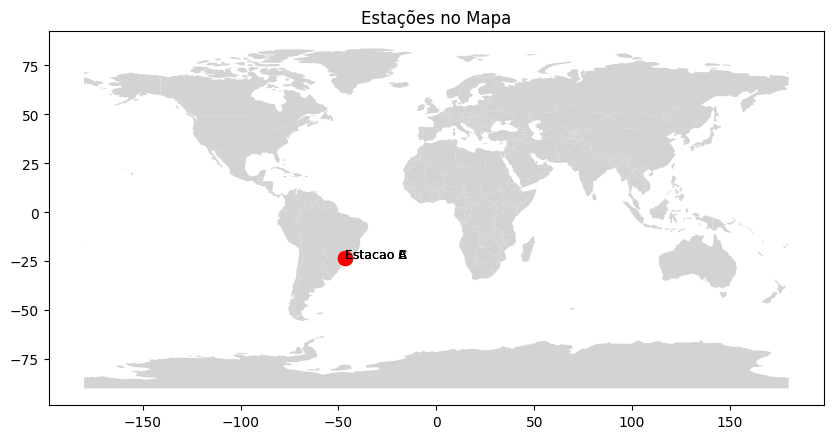

In [6]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Suponha que você tenha um DataFrame com informações das estações e suas coordenadas geográficas
# Aqui, estou criando um exemplo fictício para ilustração
data = {
    'Estacao': ['Estacao A', 'Estacao B', 'Estacao C'],
    'Latitude': [-23.550520, -23.560520, -23.570520],
    'Longitude': [-46.633308, -46.643308, -46.653308]
}

df_estacoes = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data['Longitude'], data['Latitude']))

# Carregar um mapa base (pode ser um shapefile ou GeoJSON)
# Aqui, estou usando um mapa simplificado do Brasil como exemplo
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Plotar o mapa base
ax = world.plot(figsize=(10, 6), color='lightgray')

# Adicionar as estações ao mapa
df_estacoes.plot(ax=ax, marker='o', color='red', markersize=100)

# Adicionar rótulos para as estações
for x, y, label in zip(df_estacoes.geometry.x, df_estacoes.geometry.y, df_estacoes['Estacao']):
    ax.text(x, y, label, fontsize=9)

# Configurar o título do mapa
plt.title('Estações no Mapa')

# Exibir o gráfico
plt.show()


In [5]:
!pip install matplotlib geopandas


     ---------------------------------------- 0.0/51.1 kB ? eta -:--:--
     ---------------------------------------- 51.1/51.1 kB 1.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   ----- ---------------------------------- 0.1/1.1 MB 4.3 MB/s eta 0:00:01
   --------- ------------------------------ 0.3/1.1 MB 4.2 MB/s eta 0:00:01
   --------------------- ------------------ 0.6/1.1 MB 4.7 MB/s eta 0:00:01
   ---------------------------- ----------- 0.8/1.1 MB 4.5 MB/s eta 0:00:01
   ---------------------------------------  1.1/1.1 MB 5.0 MB/s eta 0:00:01
   ---------------------------------------- 1.1/1.1 MB 4.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/22.9 MB ? eta -:--:--
    --------------------------------------- 0.4/22.9 MB 7.6 MB/s eta 0:00:03
   - -------------------------------------- 0.6/22.9 MB 6.3 MB/s eta 0:00:04
   - -------------------------------------- 0.9/22.9 MB 6.3 MB/s eta 0:00:04
   -- ----------------